# NeuralStocks LSTM

В этом Python Notebook представлена тестовая версия автотрейдинговой системы, основанной на машинном обучении и индикаторах технического анализа.

Для построения такой системы нам понадобятся несколько библиотек. В первую очередь это yfinance, с помощью которой мы
будем получать данные. Для их чтения, обработки и преобразования в подходящий для обучения вид потребуются pandas_datareader, pandas и numpy. Для удобства возможных математических расчетов используем math. Для построения графиков понадобится matplotlib. Наконец, для инициализации нейросети нужна библиотека tensorflow.

In [1]:
import yfinance as yf
import pandas_datareader.data as pdr
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf

yf.pdr_override()
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from stockstats import StockDataFrame as sdf

### Let's get prices

Здесь описана функция для получения данных с торгов за определенный период для компании или индекса с определенным тикером.

Функция get_stock_data со следующими параметрами возвращает excel-таблицу (stock_data.csv) с данными торгов.

    ticker - в виде строки или массива строк заносим тикер интересующей компании или индекса
    start_date - в виде ГГГГ-ММ-ДД заносим начало интересующего периода
    end_date - конец периода

В данном случае из всех атрибутов мы возьмем дату (индекс) и цены открытия, закрытия, максимума и минимума. На их основе рассчитаем скользящую среднюю - главный технический индикатор, с которым мы и будем работать.

In [81]:
def get_stock_data(ticker, start_date, end_date):
    all_data = pdr.get_data_yahoo(ticker, start_date, end_date)
    OHLC_data = all_data[["Open","High","Low","Close"]]
    OHLC_avg = OHLC_data.mean(axis = 1)
    
    OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    OHLC_avg = scaler.fit_transform(OHLC_avg)
    return OHLC_avg

Вот как это выглядит

In [82]:
all_data = pdr.get_data_yahoo("BA", "2018-05-01", "2018-06-01")
print(all_data)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-04-30  341.170013  342.579987  333.399994  333.559998  319.449463   
2018-05-01  332.500000  333.910004  324.179993  329.540009  315.599548   
2018-05-02  329.500000  330.709991  323.980011  324.190002  310.475861   
2018-05-03  322.970001  332.630005  319.130005  330.690002  316.700867   
2018-05-04  328.040009  335.890015  328.040009  334.429993  320.282654   
2018-05-07  335.230011  342.980011  335.209991  340.429993  326.028839   
2018-05-08  339.769989  341.940002  336.609985  338.369995  324.056000   
2018-05-09  339.489990  346.929993  338.579987  344.500000  329.926666   
2018-05-10  343.989990  348.570007  342.410004  344.070007  331.158661   
2018-05-11  343.769989  345.420013  341.049988  342.459991  329.609070   
2018-05-14  344.000000  347.739990  343.890

А если изобразить на графике, то так:

C:\Users\Дмитрий В\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


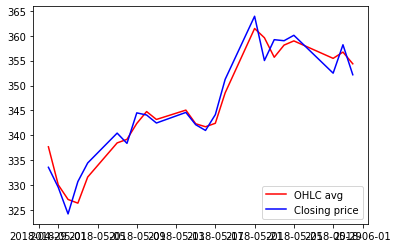

In [83]:
OHLC_data = all_data[["Open","High","Low","Close"]]
OHLC_avg = OHLC_data.mean(axis = 1)
closing = all_data["Close"]
#OHLC_avg.plot()

plt.plot(OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(closing, 'b', label = 'Closing price')
plt.legend(loc = 'lower right')
plt.show()

### Now it's time for preprocessing

Нормализуем значения, то есть поместим их в определенный удобный промежуток. В нашем случае - от 0 до 1.

Было так:

In [84]:
OHLC_avg

Date
2018-04-30    337.677498
2018-05-01    330.032501
2018-05-02    327.095001
2018-05-03    326.355003
2018-05-04    331.600006
2018-05-07    338.462502
2018-05-08    339.172493
2018-05-09    342.374992
2018-05-10    344.760002
2018-05-11    343.174995
2018-05-14    345.055000
2018-05-15    342.307503
2018-05-16    341.707497
2018-05-17    342.407501
2018-05-18    348.517502
2018-05-21    361.457504
2018-05-22    359.597496
2018-05-23    355.677498
2018-05-24    358.120003
2018-05-25    358.964996
2018-05-29    355.455002
2018-05-30    356.715004
2018-05-31    354.359993
dtype: float64

А стало вот так:

In [85]:
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)
print(OHLC_avg)

[[0.32255521]
 [0.10476455]
 [0.02108106]
 [0.        ]
 [0.14941963]
 [0.34491839]
 [0.36514463]
 [0.45637743]
 [0.52432158]
 [0.47916791]
 [0.53272549]
 [0.45445478]
 [0.43736181]
 [0.45730354]
 [0.63136523]
 [1.        ]
 [0.94701209]
 [0.83533919]
 [0.90492126]
 [0.92899344]
 [0.82900072]
 [0.86489566]
 [0.79780611]]


Теперь создадим тренировочный и тестовый сеты в функции generator, разделив исходную выборку пропорционально задаваемому соотношению. Аргументами функции будут:

    dataset - наши данные о скользящей средней в виде массива размерности 1
    train_part - число от 0 до 1 (обычно 0.7-0.9), задающее часть выборки, которая будет использоваться для обучения
    step_size - размер шага в днях

Функция возвращает соответственно тренировочные и тестовые массивы временных рядов

In [86]:
def generator(dataset, train_part, step_size):

# делим на тренировочную и тестовую выборки
    part = int(len(dataset) * train_part)
    train_OHLC = dataset[0: part]
    test_OHLC = dataset[part:]

    trainX = []
    trainY = []
    testX = []
    testY = []

#заполняем массивы значениями
    for i in range(len(train_OHLC) - step_size - 1):
        x = np.array(train_OHLC[i: i + step_size, 0])
        y = np.array([train_OHLC[i + step_size, 0]], np.float64)
        
        trainX.append(x)
        trainY.append(y)

# выборка для времени Т, значения для Т+1
    X_train = np.array(trainX)
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    Y_train = np.array(trainY).flatten()

#аналогично
    for i in range(len(test_OHLC) - step_size - 1):
        x = np.array(test_OHLC[i: i + step_size, 0])
        y = np.array([test_OHLC[i + step_size, 0]], np.float64)
        
        testX.append(x)
        testY.append(y)

    X_test = np.array(testX)
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    Y_test = np.array(testY).flatten()

#искомые наборы данных
    return X_train, Y_train, X_test, Y_test

Вот как выглядит результат работы этой функции:

In [87]:
generator(OHLC_avg, 0.9, 1)

(array([[[0.32255521]],
 
        [[0.10476455]],
 
        [[0.02108106]],
 
        [[0.        ]],
 
        [[0.14941963]],
 
        [[0.34491839]],
 
        [[0.36514463]],
 
        [[0.45637743]],
 
        [[0.52432158]],
 
        [[0.47916791]],
 
        [[0.53272549]],
 
        [[0.45445478]],
 
        [[0.43736181]],
 
        [[0.45730354]],
 
        [[0.63136523]],
 
        [[1.        ]],
 
        [[0.94701209]],
 
        [[0.83533919]]]),
 array([0.10476455, 0.02108106, 0.        , 0.14941963, 0.34491839,
        0.36514463, 0.45637743, 0.52432158, 0.47916791, 0.53272549,
        0.45445478, 0.43736181, 0.45730354, 0.63136523, 1.        ,
        0.94701209, 0.83533919, 0.90492126]),
 array([[[0.82900072]]]),
 array([0.86489566]))

Теперь возьмем большой промежуток времени, например год, и подготовим наши выборки для реального обучения с помощью нейросети:

In [88]:
start = "2018-01-01"
end = "2019-01-01"
ticker = "BA"
train_part = 0.9
step_size = 1

OHLC_avg = get_stock_data(ticker=ticker, start_date=start, end_date=end)

X_train, Y_train, X_test, Y_test = generator(OHLC_avg, train_part, step_size)

[*********************100%***********************]  1 of 1 completed


### Neural Network creation

Данные загружены и обработаны. Пришло время обучить нашу нейросеть согласно модели LongShortTermMemory

In [89]:
#инициализируем
model = tf.keras.Sequential()

#добавляем слои
model.add(tf.keras.layers.LSTM(256, input_shape=(1, step_size), return_sequences=True))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.LSTM(128, return_sequences=True)) #возвращаем последний output
model.add(tf.keras.layers.LSTM(128, return_sequences=False)) #возвращаем весь output
model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(1, activation='linear'))


#компилируем и обучаем
model.compile(optimizer="adam", loss="mse")
model.fit(X_train, Y_train, epochs=5, batch_size=8)

Train on 223 samples
Epoch 1/5
223/223 [==============================] - 4s 17ms/sample - loss: 0.1283
Epoch 2/5
223/223 [==============================] - 0s 1ms/sample - loss: 0.0210
Epoch 3/5
223/223 [==============================] - 0s 1ms/sample - loss: 0.0141
Epoch 4/5
223/223 [==============================] - 0s 1ms/sample - loss: 0.0095
Epoch 5/5
223/223 [==============================] - 0s 1ms/sample - loss: 0.0056


In [90]:
print(model.evaluate(X_test, Y_test))

24/24 [==============================] - 1s 31ms/sample - loss: 0.0102
0.010242298245429993


In [91]:
#создаем массивы предсказанных значений
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [92]:
#денормализуем, т.е. переводим наши значения из диапазона [0,1] в цены для построения удобного графика
trainPredict = scaler.inverse_transform(trainPredict)
Y_train = scaler.inverse_transform([Y_train])
testPredict = scaler.inverse_transform(testPredict)
Y_test = scaler.inverse_transform([Y_test])
OHLC_avg = scaler.inverse_transform(OHLC_avg)

In [93]:
#считаем среднеквадратичную ошибку на train
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

#и на test
testScore = math.sqrt(mean_squared_error(Y_test[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Train RMSE: 1.96
Test RMSE: 3.55


Создаем массивы нужного размера, чтоб занести туда предсказанные данные и построить график

In [94]:
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict


testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

Строим график. на котором сопоставляем действительную цену, а также предсказанную на тренировочной и тестовой выборках

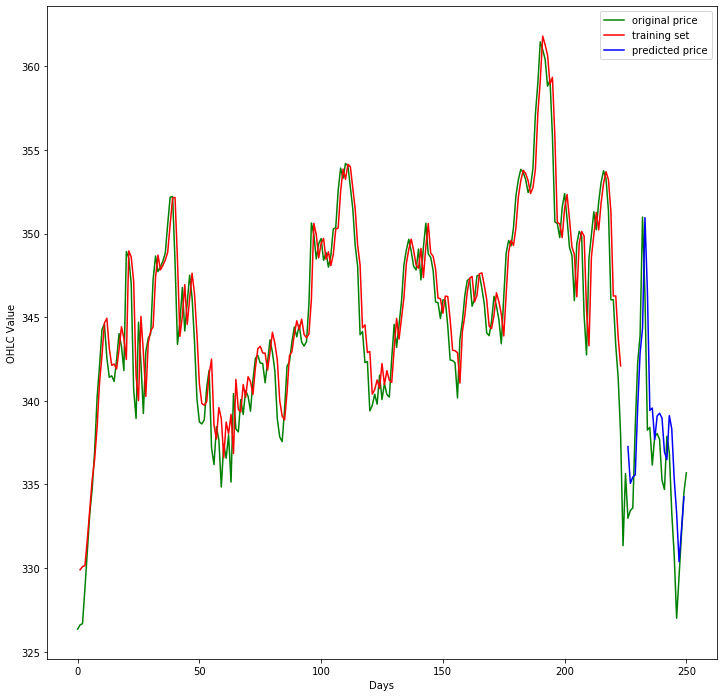

In [95]:
plt.figure(figsize=(12, 12))
plt.plot(OHLC_avg, 'g', label = 'original price')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted price')
plt.legend(loc = 'upper right')
plt.xlabel('Days')
plt.ylabel('OHLC Value')
plt.show()

In [96]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
next_day = last_val*next_val
print ("Last Day Value:", last_val.item())
print ("Next Day Value:", next_day.item())
# print np.append(last_val, next_val)

Last Day Value: 334.2622985839844
Next Day Value: 337.4940490722656


# Trend Following

Попробуем предсказывать не просто значение на следующий день, а тренд на несколько дней или недель вперед. Загрузим историю 
торгов Boeing за 10 лет, из которых на 9 годах будем обучаться, а 1 год - прогнозировать

In [2]:
data_boeing = pdr.get_data_yahoo('MSFT', '2010-05-17', '2020-06-01')
data_boeing.to_csv('boeing.csv')

[*********************100%***********************]  1 of 1 completed


In [3]:
stock_data = pd.read_csv('boeing.csv')
stock_data = sdf.retype(stock_data)
stock_data['rsi_6']
stock_data['rsi_20']
stock_data['macd']
stock_data['cci']
stock_data['kdjk']
stock_data['atr']
#del stock['close_-1_s']
#del stock['close_-1_d']
#del stock['rs_6']

C:\Users\Дмитрий В\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
D:\Anaconda\lib\site-packages\stockstats.py:474: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  lambda x: np.fabs(x - x.mean()).mean())


date
2010-05-17         NaN
2010-05-18    0.600000
2010-05-19    0.755556
2010-05-20    0.914808
2010-05-21    0.846644
                ...   
2020-05-22    4.818907
2020-05-26    4.860413
2020-05-27    4.898240
2020-05-28    4.817651
2020-05-29    4.749247
Name: atr, Length: 2527, dtype: float64

На этот раз, в целях усложнения модели и повышения ее эффективности, будем не просто ориентироваться на предыдущие цены.
Добавим технических индикаторов: индекс RSI и несколько разновидностей скользящих средних с разной длиной

Из стандартных данных YahooFinance будем брать цену закрытия(ее и будем предсказывать) и объем торгов

In [4]:
stock_data[['close','volume','rsi_6','rsi_20','macd','cci','kdjk','tr']][14:]

,close,volume,rsi_6,rsi_20,macd
date,,,,,
2010-06-07,25.290001,80456200,30.944950,28.820791,-0.213122
2010-06-08,25.110001,87355000,28.973983,27.897910,-0.253451
2010-06-09,24.790001,87794000,25.508019,26.320699,-0.300866
2010-06-10,25.000000,78930900,31.921244,29.089998,-0.320244
2010-06-11,25.660000,68057700,48.607949,36.932149,-0.288903
...,...,...,...,...,...
2020-05-22,183.509995,20826900,53.681456,56.597188,3.948136
2020-05-26,181.570007,36073600,44.279616,54.836525,3.572572
2020-05-27,181.809998,39517100,45.691606,55.018740,3.256757


In [26]:
train_part = 0.9
cols = ['close','volume','rsi_6','macd']
split = int((len(stock_data)-14) * train_part)
data_train = stock_data.get(cols).values[14:split]
data_test = stock_data.get(cols).values[split:]
len_train = len(data_train)
len_test = len(data_test)

In [27]:
def normalise(data, single_block=False):
        normalised_data = []
        data = [data] if single_block else data
        for i in data:
            normalised_block = []
            for j in range(i.shape[1]):
                normalised_column = [((float(value) / float(i[0, j])) - 1) for value in i[:, j]]
                normalised_block.append(normalised_column)
            normalised_block = np.array(normalised_block).T
            normalised_data.append(normalised_block)
        return np.array(normalised_data)

In [28]:
def generator_2(seq_len):
    data_x = []
    data_y = []
    data = []
    
    for i in range(len_train - seq_len):
        block = data_train[i:i+seq_len]
        block = normalise(block, single_block=True)[0]
        x = block[:-1]
        y = block[-1, [0]]
        data_x.append(x)
        data_y.append(y)
    
    for j in range(len_test - seq_len):
        data.append(data_test[j:j+seq_len])
    data = np.array(data).astype(float)
    data_normalized = normalise(data, single_block=False)
    
    return np.array(data_x), np.array(data_y), data, data_normalized


x_train, y_train, test_data, test_data_normalized = generator_2(seq_len=7)

x_test = test_data_normalized[:, :-1]
y_test = test_data_normalized[:, -1, [0]]

In [29]:
input_timesteps = 6
input_dim = 4

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(input_timesteps, input_dim), return_sequences=True))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LSTM(128, return_sequences=False))
model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(1, activation='linear'))

model.compile(optimizer="adam", loss="mse")
model.fit(x_train, y_train, epochs=3, batch_size=16)

Train on 2240 samples
Epoch 1/3
2240/2240 [==============================] - 7s 3ms/sample - loss: 9.2376e-04
Epoch 2/3
2240/2240 [==============================] - 5s 2ms/sample - loss: 6.8602e-04
Epoch 3/3
2240/2240 [==============================] - 5s 2ms/sample - loss: 5.6083e-04


In [30]:
predictions = []
timeframe = 7
prediction_len = 7

for i in range(int(len(x_test)/prediction_len)):
    segm = x_test[i * prediction_len]
    predicted = []
    for j in range(prediction_len):
        pred = model.predict(segm[np.newaxis,:,:])[0,0]
        predicted.append(pred)
        segm = segm[1:]
        segm = np.insert(segm, [timeframe-2], predicted[-1], axis=0)
    predictions.append(predicted)

In [31]:
denormalised_data = []
for i in range(len(test_data_normalized)):
    denormalised_window = []
    for col_i in range(test_data_normalized[i].shape[1]):
        denormalised_col = [((float(p) + 1) * float(test_data[i][0, col_i])) for p in test_data_normalized[i][:, col_i]]
        denormalised_window.append(denormalised_col)
    denormalised_window = np.array(denormalised_window).T
    denormalised_data.append(denormalised_window)
test_data_denormalized = np.array(denormalised_data)

x_test_denormalized = test_data_denormalized[:, :-1]
y_test_denormalized = test_data_denormalized[:, -1, [0]]


k = 0
denormalised_predictions = []
for i in range(len(predictions)):
    pred = []
    for j in range(len(predictions[i])):
        denorm = (predictions[i][j] + 1) * test_data[k][0, 0]
        k = k + 1
        pred.append(denorm)
    denormalised_predictions.append(pred)

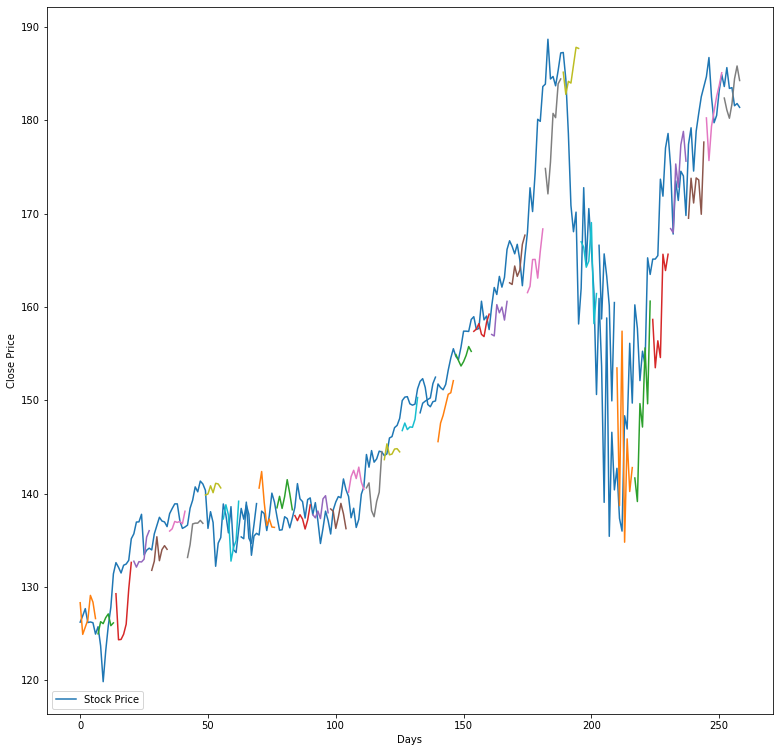

In [32]:
fig = plt.figure(figsize=(13, 13))
plt.plot(y_test_denormalized, label='Stock Price')

for i, data in enumerate(denormalised_predictions):
    padding = [None for p in range(i * 7)]
    plt.plot(padding + data)
plt.legend(loc = 'lower left')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.show()

# Нормализованные графики

In [ ]:
fig = plt.figure(figsize=(15, 15))
plt.plot(y_test, label='Stock Price')

for i, data in enumerate(predictions):
    padding = [None for p in range(i * 7)]
    plt.plot(padding + data)
plt.legend(loc = 'lower left')
plt.xlabel('Days')
plt.ylabel('Close Price (Normalized)')
plt.show()